*italicized text*## Linear Function Approximator

In [1]:
import numpy as np
import matplotlib.pyplot as plt


class LinearFunctionApproximator:
    def __init__(self, num_features):
        self.theta = np.random.rand(num_features)

    def predict(self, phi_s):
      return np.dot(self.theta, phi_s)

    def update(self, phi_s, target):
        prediction = self.predict(phi_s)
        error = target - prediction
        self.theta += 0.1 * error * phi_s

In [2]:
num_features = 2
approximator = LinearFunctionApproximator(num_features)
num_episodes = 1000

for episode in range(num_episodes):
    phi_s = np.random.rand(num_features)
    target_value = 10 * phi_s[0] + 5 * phi_s[1]
    approximator.update(phi_s, target_value)

test = np.array([0.8, 0.2])
predicted_value = approximator.predict(test)
print(f"Predicted Value for phi_s {test}: {predicted_value}")

Predicted Value for phi_s [0.8 0.2]: 8.999698232401716


## Sin

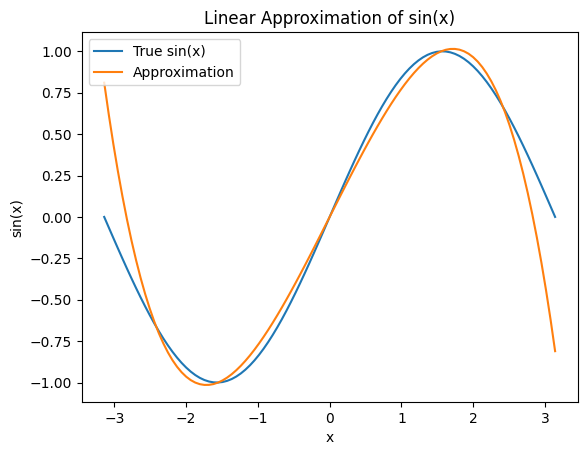

In [4]:
num_terms = 3
approximator = LinearFunctionApproximator(num_terms)
num_episodes = 1000

for episode in range(num_episodes):
    x = np.random.uniform(-np.pi, np.pi)
    features = np.array([x**i / np.math.factorial(i) for i in range(1, 2 * num_terms, 2)])
    target_value = np.sin(x)
    approximator.update(features, target_value)


test_x_values = np.linspace(-np.pi, np.pi, 100)
predicted_values = [approximator.predict([x**i / np.math.factorial(i) for i in range(1, 2 * num_terms, 2)]) for x in test_x_values]

plt.plot(test_x_values, np.sin(test_x_values), label='True sin(x)')
plt.plot(test_x_values, predicted_values, label='Approximation')
plt.legend()
plt.title('Linear Approximation of sin(x)')
plt.xlabel('x')
plt.ylabel('sin(x)')
plt.show()

## Policy Gradient in Reinforcement Learning

First, please install the required packages and import these modules.

In [5]:
%%capture
!pip install python-opengl
!pip install ffmpeg
!pip install xvfb
!pip install pyvirtualdisplay
!pip install pyglet==1.5.1
!pip install imageio-ffmpeg
!pip install pyyaml==6.0
!pip install git+https://github.com/ntasfi/PyGame-Learning-Environment.git
!pip install git+https://github.com/simoninithomas/gym-games


In [6]:
import numpy as np

from collections import deque

import matplotlib.pyplot as plt
%matplotlib inline

# PyTorch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.distributions import Categorical

# Gym
import gym
import gym_pygame

import imageio

In policy gradient, the action $a$ is picked up by the distribution $P$ which depends on policy $\pi$.<br>
To say more clearly, the distibution of action is $ P(a | \pi_\theta (s)) $, where $ \pi_\theta (s) $ is policy and $\theta$ is parameters for this policy. When the current state $s$ is given, the distribution of action $a$ is determined by this policy.

In this CartPole example, we assume that $P(\cdot)$ is a categorical distribution (because action space is discrete) and $\pi_\theta (s)$ is the following fully-connected network (fcnet).<br>
In this example, the output of this policy $\pi_\theta (s)$ will be logits value, which determines categorical distribution $P(\cdot)$.

![](https://www.researchgate.net/publication/360910430/figure/fig1/AS:11431281080452861@1661307888574/Deep-reinforcement-learning-scheme-A-deep-neural-network-learns-the-policy_W640.jpg)

> Note : When logits $v_0, v_1$ are given, the probabilities are $\frac{e^{v_0}}{e^{v_0}+e^{v_1}}, \frac{e^{v_1}}{e^{v_0}+e^{v_1}}$ respectively.

First, we implement $\pi_\theta (s)$ (fully-connected network) using PyTorch as follows.

### impelement network

In [7]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
class Policy(nn.Module):
  # a_size: output layer
  # s_size: input layer
  # h_size: hidden layer
    def __init__(self, s_size, a_size, h_size):
        super(Policy, self).__init__()
        # self.fc1 = ...
        self.fc1=nn.Linear(s_size,h_size)
        # self.fc2 = ...
        self.fc2=nn.Linear(h_size,h_size*2)
        self.fc3=nn.Linear(h_size*2,a_size)


    def forward(self, x):
        # x = F.relu(...)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)

        #out = ...(x, dim=1)
        out = F.softmax(x, dim=1)

        return out

    def act(self, state):
        state = torch.from_numpy(state).float().unsqueeze(0).to(device)
        # probs = self.forward(...).cpu()
        probs = self.forward(state).cpu()

        # m = Categorical(...)
        m = Categorical(probs)

        action = m.sample()
        return action.item(), m.log_prob(action)

### define environment
https://gymnasium.farama.org/environments/classic_control/

In [8]:
env_id = "CartPole-v1"
# Create the env
env = gym.make(env_id)

# Create the evaluation env
eval_env = gym.make(env_id)

# Get the state space and action space
s_size = env.observation_space.shape[0]
a_size = env.action_space.n

/usr/local/lib/python3.10/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(


In [9]:
print("_____OBSERVATION SPACE_____ \n")
print("The State Space is: ", s_size)
print("Sample observation", env.observation_space.sample()) # Get a random observation

_____OBSERVATION SPACE_____ 

The State Space is:  4
Sample observation [-4.4522367e+00 -1.1591133e+38 -3.4566358e-01 -1.6944983e+38]


In [10]:
print("\n _____ACTION SPACE_____ \n")
print("The Action Space is: ", a_size)
print("Action Space Sample", env.action_space.sample()) # Take a random action


 _____ACTION SPACE_____ 

The Action Space is:  2
Action Space Sample 0


### Let's build the Reinforce Training Algorithm
This is the Reinforce algorithm pseudocode:

<img src="https://huggingface.co/datasets/huggingface-deep-rl-course/course-images/resolve/main/en/unit6/pg_pseudocode.png" alt="Policy gradient pseudocode"/>

In [23]:
def reinforce(policy, optimizer, n_training_episodes, max_t, gamma, print_every):
    # Help us to calculate the score during the training
    scores_deque = deque(maxlen=100)
    scores = []
    # Line 3 of pseudocode
    for i_episode in range(1, n_training_episodes+1):
        saved_log_probs = []
        rewards = []  # Change the name to rewards to avoid conflict
        # Initialize the state
        state = env.reset()
        # Line 4 of pseudocode
        for t in range(max_t):
            # get the action and probability from the network
            action, log_prob = policy.act(state)
            saved_log_probs.append(log_prob)  # save the probability
            # make action and get state and reward from env
            state, reward_t, done, a = env.step(action)
            rewards.append(reward_t)  # Change the name to reward_t to avoid conflict
            if done:
                break
        scores_deque.append(sum(rewards))
        scores.append(sum(rewards))

        # Line 6 of pseudocode: calculate the return
        returns = deque(maxlen=max_t)
        n_steps = len(rewards)
        # Compute the discounted returns at each timestep
        for t in range(n_steps)[::-1]:
            disc_return_t = (returns[0] if len(returns) > 0 else 0)
            # discounted reward
            returnn = gamma * disc_return_t + rewards[t]  # Change to rewards[t]

            returns.appendleft(returnn)

        # standardization of the returns is employed to make training more stable
        eps = np.finfo(np.float32).eps.item()
        returns = torch.tensor(returns)
        returns = (returns - returns.mean()) / (returns.std() + eps)

        # Line 7:
        policy_loss = []
        for log_prob, disc_return in zip(saved_log_probs, returns):
            # calculate policy loss
            pol_loss = -log_prob * disc_return

            policy_loss.append(pol_loss)
        policy_loss = torch.cat(policy_loss).sum() / n_steps

        # Line 8: PyTorch prefers gradient descent
        optimizer.zero_grad()
        policy_loss.backward()
        optimizer.step()

        if i_episode % print_every == 0:
            print('Episode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_deque)))

    return scores


#### Define parameters

In [24]:
cartpole_hyperparameters = {
    "h_size": 16,
    "n_training_episodes": 1000,
    "n_evaluation_episodes": 10,
    "max_t": 1000,
    "gamma": 1.0,
    "lr": 1e-2,
    "env_id": env_id,
    "state_space": s_size,
    "action_space": a_size,
}

### Start!

In [25]:
# Create policy and place it to the device
cartpole_policy = Policy(cartpole_hyperparameters["state_space"], cartpole_hyperparameters["action_space"], cartpole_hyperparameters["h_size"]).to(device)
cartpole_optimizer = optim.Adam(cartpole_policy.parameters(), lr=cartpole_hyperparameters["lr"])

In [26]:
scores = reinforce(cartpole_policy,
                   cartpole_optimizer,
                   cartpole_hyperparameters["n_training_episodes"],
                   cartpole_hyperparameters["max_t"],
                   cartpole_hyperparameters["gamma"],
                   100)

Episode 100	Average Score: 61.84
Episode 200	Average Score: 307.62
Episode 300	Average Score: 302.75
Episode 400	Average Score: 397.54
Episode 500	Average Score: 305.92
Episode 600	Average Score: 479.65
Episode 700	Average Score: 452.25
Episode 800	Average Score: 462.87
Episode 900	Average Score: 469.58
Episode 1000	Average Score: 500.00


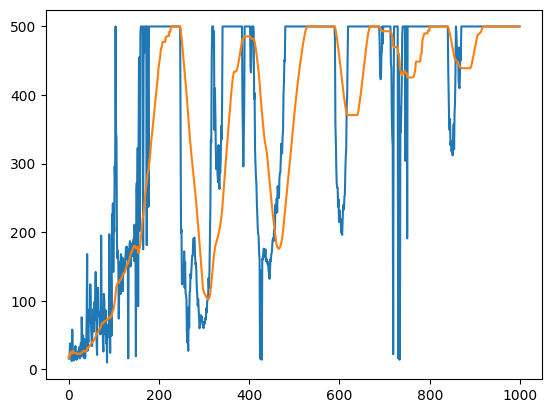

In [27]:
import matplotlib.pyplot as plt
# Generate recent 50 interval average
average_reward = []
for idx in range(len(scores)):
    avg_list = np.empty(shape=(1,), dtype=int)
    if idx < 50:
        avg_list = scores[:idx+1]
    else:
        avg_list = scores[idx-49:idx+1]
    average_reward.append(np.average(avg_list))
# Plot
plt.plot(scores)
plt.plot(average_reward)

In [28]:
def evaluate_agent(env, max_steps, n_eval_episodes, policy):
  """
  Evaluate the agent for ``n_eval_episodes`` episodes and returns average reward and std of reward.
  :param env: The evaluation environment
  :param n_eval_episodes: Number of episode to evaluate the agent
  :param policy: The Reinforce agent
  """
  episode_rewards = []
  for episode in range(n_eval_episodes):
    state = env.reset()
    step = 0
    done = False
    total_rewards_ep = 0

    for step in range(max_steps):
      action, _ = policy.act(state)
      new_state, reward, done, info = env.step(action)
      total_rewards_ep += reward

      if done:
        break
      state = new_state
    episode_rewards.append(total_rewards_ep)
  mean_reward = np.mean(episode_rewards)
  std_reward = np.std(episode_rewards)

  return mean_reward, std_reward

In [29]:
evaluate_agent(eval_env,
               cartpole_hyperparameters["max_t"],
               cartpole_hyperparameters["n_evaluation_episodes"],
               cartpole_policy)

(497.3, 5.514526271584895)

In [31]:
def record_video(env, policy, out_directory, fps=30):
  """
  Generate a replay video of the agent
  :param env
  :param Qtable: Qtable of our agent
  :param out_directory
  :param fps: how many frame per seconds (with taxi-v3 and frozenlake-v1 we use 1)
  """
  images = []
  done = False
  state = env.reset()
  img = env.render(mode='rgb_array')
  images.append(img)
  while not done:
    # Take the action (index) that have the maximum expected future reward given that state
    action, _ = policy.act(state)
    state, reward, done, info = env.step(action) # We directly put next_state = state for recording logic
    img = env.render(mode='rgb_array')
    images.append(img)
  imageio.mimsave(out_directory + '.mp4', [np.array(img) for i, img in enumerate(images)], fps=fps)

In [32]:
video_path = 'ty1'
record_video(env, cartpole_policy, video_path, 30)
from IPython.display import Video
Video('/content/'+video_path +'.mp4', embed=True)

/usr/local/lib/python3.10/dist-packages/gym/core.py:43: DeprecationWarning: WARN: The argument mode in render method is deprecated; use render_mode during environment initialization instead.
See here for more information: https://www.gymlibrary.ml/content/api/
  deprecation(


## Deep Sarsa

https://github.com/JohDonald/Deep-Q-Learning-Deep-SARSA-LunarLander-v2/blob/main/DSN_and_DQN_LunarLander.ipynb

https://github.com/rlcode/reinforcement-learning/tree/master/1-grid-world/6-deep-sarsa

In [47]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.distributions import Categorical

class SARSAPolicy(nn.Module):
    def __init__(self, s_size, a_size, h_size):
        super(SARSAPolicy, self).__init__()
        self.fc1 = nn.Linear(s_size, h_size)
        self.fc2 = nn.Linear(h_size, h_size * 2)
        self.fc3 = nn.Linear(h_size * 2, a_size)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        out = F.softmax(x, dim=1)
        return out

    def act(self, state):
        state = torch.from_numpy(state).float().unsqueeze(0).to(device)
        probs = self.forward(state).cpu()
        m = Categorical(probs)
        action = m.sample()
        return action.item(), m.log_prob(action)

    def q_values(self, state):
        if not isinstance(state, torch.Tensor):
            state = torch.from_numpy(state).float().unsqueeze(0).to(device)
        return self.forward(state)

def sarsa_update(policy, optimizer, state, action, reward, next_state, next_action, gamma):
    state = torch.from_numpy(state).float().unsqueeze(0).to(device)
    next_state = torch.from_numpy(next_state).float().unsqueeze(0).to(device)

    current_q_values = policy.q_values(state).gather(1, torch.tensor([[action]]))
    next_q_values = policy.q_values(next_state).gather(1, torch.tensor([[next_action]]))

    target = reward + gamma * next_q_values.item()
    loss = F.smooth_l1_loss(current_q_values, torch.tensor([[target]]).to(device))

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

In [48]:
# Hyperparameters for SARSA
sarsa_hyperparameters = {
    "h_size": 16,
    "n_training_episodes": 1000,
    "n_evaluation_episodes": 10,
    "max_t": 1000,
    "gamma": 1.0,
    "lr": 1e-2,
    "env_id": env_id,
    "state_space": s_size,
    "action_space": a_size,}

In [49]:
# Create SARSA policy and optimizer
sarsa_policy = SARSAPolicy(sarsa_hyperparameters["state_space"], sarsa_hyperparameters["action_space"], sarsa_hyperparameters["h_size"]).to(device)
sarsa_optimizer = optim.Adam(sarsa_policy.parameters(), lr=sarsa_hyperparameters["lr"])


In [50]:
# SARSA training loop
for episode in range(sarsa_hyperparameters["n_training_episodes"]):
    state = env.reset()
    action, _ = sarsa_policy.act(state)
    total_reward = 0

    for t in range(sarsa_hyperparameters["max_t"]):
        next_state, reward, done, _ = env.step(action)
        next_action, _ = sarsa_policy.act(next_state)
        sarsa_update(sarsa_policy, sarsa_optimizer, state, action, reward, next_state, next_action, sarsa_hyperparameters["gamma"])

        total_reward += reward
        state = next_state
        action = next_action

        if done:
            break


In [51]:
# Evaluation
mean_reward, std_reward = evaluate_agent(eval_env, sarsa_hyperparameters["max_t"], sarsa_hyperparameters["n_evaluation_episodes"], sarsa_policy)
print(f"Mean Reward: {mean_reward}, Std Reward: {std_reward}")


Mean Reward: 9.2, Std Reward: 0.6


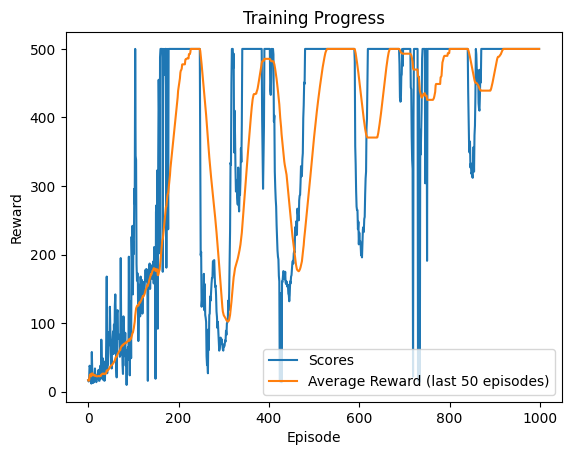

In [52]:
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation

# Generate recent 50 interval average
average_reward = []
for idx in range(len(scores)):
    avg_list = np.empty(shape=(1,), dtype=int)
    if idx < 50:
        avg_list = scores[:idx+1]
    else:
        avg_list = scores[idx-49:idx+1]
    average_reward.append(np.average(avg_list))

# Create a function to update the plot for each frame
def update_plot(frame):
    plt.clf()  # Clear the previous plot
    plt.plot(scores[:frame])
    plt.plot(average_reward[:frame])
    plt.legend(['Scores', 'Average Reward (last 50 episodes)'])
    plt.xlabel('Episode')
    plt.ylabel('Reward')
    plt.title('Training Progress')

# Set up the figure and animation
fig, ax = plt.subplots()
animation = FuncAnimation(fig, update_plot, frames=len(scores), interval=100, repeat=False)

# Save the animation as a video
video_out_directory = "/content/training_progress_video"
animation.save(video_out_directory + '.mp4', writer='ffmpeg', fps=10)

plt.show()
